## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()*100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query("(group == 'treatment' and landing_page == 'old_page')").shape[0]

1965

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


#number of non-null equals the number of rows, so no null values

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df.query("group == 'treatment' and landing_page == 'new_page' or group == 'control' and landing_page == 'old_page'")

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates('user_id')
#To check
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
P_population = df2.converted.mean()
P_population

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
P_control = df2[df2['group'] == 'control'].converted.mean()
P_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
P_treatment = df2[df2['group'] == 'treatment'].converted.mean()
P_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

In [18]:
P_treatment - P_control

-0.0015782389853555567

**Your answer goes here.**
The new page leads to a negligible increase in conversion, bearing in mind that enough individuals received the new page (50%) then we can says confidently that the new page has almost not affected the conversion rate. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

H0:Pold ≥ Pnew

H1:Pold < Pnew

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_null = df2['converted'].mean()
p_new = p_null
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = p_null
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new=(df2.landing_page == "new_page").sum()
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old=(df2.landing_page == "old_page").sum()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
pnew = new_page_converted.mean()

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
pold = old_page_converted.mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
pnew-pold

0.0007207607495036406

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())
    
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

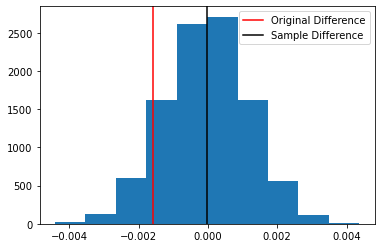

In [27]:
diff_org = P_treatment - P_control
plt.hist(p_diffs)
plt.axvline(x=(diff_org), color = 'red', label='Original Difference')
plt.axvline(x=(p_diffs.mean()), color = 'black', label='Sample Difference')
plt.legend()
plt.show()


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs > diff_org).mean()

0.8998

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**
The value calculated in j. is called p-value.
A p-value of 90% which is much more than type I error, this means we fail to reject the null hypothesis. Indicating no significant difference between the conversion rate of the two pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))

convert_new =len(df2.query('landing_page == "new_page" & converted == 1'))

n_old = (df2.landing_page == "old_page").sum()

n_new = (df2.landing_page == "new_page").sum()

convert_old , convert_new , n_old , n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative='larger')

print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

***Put your answer here.**
*The Z-score here is -1.31 which is much lower than Zα (Z0.05 is 1.645 for one-tailed tests) and the test is right-tailed so we failed to reject the null hypothesis. Thus, the new page lack the statistical significance that it is better than the old one (in terms of conversion rate).
*The p-value computed here is closely similar to the previousley computed. Hence, the same conclusion apply as depending on the results we fail to reject the null hypothesis.
*Both values are consistant in that the results do not favour the new page use.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**
We should perform a logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
df2[['control','ab_page']]=pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
import statsmodels.api as sm

model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-08-26 05:16 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**
P-value here is 0.1899 and iti is different from PART II because the hypothesis in logistic regression is two-sided. The null hypothesis in logistic regression is that there is no association between the term and the response (treatment and conversion).
Since the P-value is 0.1899 which is greater than the alfa(Type I error rate (0.05), we fail to reject the null hypothesis. 


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
*Adding or testing other factors like adding the timestamp (after some modification maybe) could reveal a new factor of influence on conversion rate as a whole or in particular to old or new page.
*However, this will come with some disadvantages because the model will be more complex and make coefficients difficult to interpret . Also, we need to check if there is any Multicollinearity. Other problems may evolve like outliers and overfitting.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [34]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.nunique()

country              3
timestamp       290584
group                2
landing_page         2
converted            2
intercept            1
control              2
ab_page              2
dtype: int64

In [35]:
### Create the necessary dummy variables
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [36]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page' , 'UK' , 'US']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-08-26 05:16 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

# Summary

By looking at the numerical summary, we found that all p-values provided (0.1912, 0.0745, 0.1295) are above type I error of 0.05, so we conclude that null hypothesis can not be rejected and there are no statistical evidnce that a new page or country has influence on the conversion. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [37]:
df_new['UK_new_p'] = df_new['UK'] * df_new['ab_page']
df_new['US_new_p'] = df_new['US'] * df_new['ab_page']
df_new['CA_new_p'] = df_new['CA'] * df_new['ab_page']
df_new.head()


,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US,UK_new_p,US_new_p,CA_new_p
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,1,0,0


In [38]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page' , 'UK' , 'US', 'UK_new_p', 'US_new_p']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-08-26 05:16 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_new_p       0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_new_p       0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

## Final Conclusion
*All the p-values resulted are higher than type I error rate (0.05) which indicates that we can not reject the null hypothesis. 
New page, countries and countries interacted with new page , all failed to hold a statistical signficance that even one of them has an influence on conversion. 

*Confidently, I do not recommended to apply the new page.

*Since countries do not have effect on the conversion, when testing new pages in the future I would suggest to test more than one "New page"; one in each country. By this way we can test multiple pages at the same time , hopefully one of them would exceed the desired margin of full implementation.


# Additional section

# Using the time in the analysis

In [39]:
#Convert argument to datetime.
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])

In [40]:
#Converting time to hrs format into a new column
import datetime
df_new['hrs'] = df_new['timestamp'].dt.hour
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US,UK_new_p,US_new_p,CA_new_p,hrs
user_id,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0,23
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,1,0,14
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,1,0,0,14
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0,0,3
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,1,0,0,13


In [41]:
#Checking the hrs column
df_new.nunique()

country              3
timestamp       290584
group                2
landing_page         2
converted            2
intercept            1
control              2
ab_page              2
CA                   2
UK                   2
US                   2
UK_new_p             2
US_new_p             2
CA_new_p             2
hrs                 24
dtype: int64

In [42]:
#Creating hour dummies
hour_dummies = pd.get_dummies(df_new['hrs'], prefix='hour')
df_new = df_new.join(hour_dummies)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
user_id,,,,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [43]:
#Checking the new columns
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 834778 to 934996
Data columns (total 39 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       290584 non-null  object        
 1   timestamp     290584 non-null  datetime64[ns]
 2   group         290584 non-null  object        
 3   landing_page  290584 non-null  object        
 4   converted     290584 non-null  int64         
 5   intercept     290584 non-null  int64         
 6   control       290584 non-null  uint8         
 7   ab_page       290584 non-null  uint8         
 8   CA            290584 non-null  uint8         
 9   UK            290584 non-null  uint8         
 10  US            290584 non-null  uint8         
 11  UK_new_p      290584 non-null  uint8         
 12  US_new_p      290584 non-null  uint8         
 13  CA_new_p      290584 non-null  uint8         
 14  hrs           290584 non-null  int64         
 15  hour_0      

In [44]:
#Apllying the model and obtaining results

log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page' ,'hour_1' ,'hour_2' ,'hour_3' ,'hour_4' ,'hour_5' ,'hour_6' ,'hour_7' ,'hour_8' ,'hour_9' ,'hour_10' ,'hour_11' ,'hour_12' ,'hour_13' ,'hour_14' ,'hour_15' ,'hour_16' ,'hour_17' ,'hour_18' ,'hour_19' ,'hour_20' ,'hour_21' ,'hour_22' ,'hour_23']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366060
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212792.0882
Date:               2022-08-26 05:16 BIC:              213056.5794
No. Observations:   290584           Log-Likelihood:   -1.0637e+05
Df Model:           24               LL-Null:          -1.0639e+05
Df Residuals:       290559           LLR p-value:      0.055126   
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -1.9816    0.0287  -68.9422  0.0000  -2.0379  -1.9253
ab_page       -0.0152    0.0114   -1.3274  0.1844  -0.0376   0.0072
hour_1        -0.0643    0.0400   -1.6055  0.1084  -0.1428   0.0142
hour_2        -0.0679    0.0402   -1.6873  0.0915  -0.1467   0.0110
hour_3        -0.0512    0.0400   -1.2791  0.2009  -0.1297   0.0273
hour_4        -0.0602    0.0402   -1.4964  0.1346  -0.1390   0.0186
hour_5         0.0052    0.0395    0.1314  0.8954  -0.0723   0.0827
hour_6         0.0092    0.0396    0.2333  0.8155  -0.0684   0.0869
hour_7        -0.0263    0.0398   -0.6615  0.5083  -0.1044   0.0517
hour_8        -0.0181    0.0398   -0.4538  0.6500  -0.0960   0.0599
hour_9         0.0450    0.0395    1.1398  0.2544  -0.0324   0.1223
hour_10       -0.0264    0.0399   -0.6630  0.5073  -0.1046   0.0517
hour_11        0.0232    0.0395    0.5869  0.5573  -0.0542   0.1005
hour_12        0.0334    0.0394    0.8473  0.3968  -0.0438   0.1106
hour_13        0.0024    0.0397    0.0615  0.9509  -0.0754   0.0803
hour_14       -0.0223    0.0397   -0.5604  0.5752  -0.1002   0.0556
hour_15        0.0080    0.0398    0.2005  0.8411  -0.0700   0.0859
hour_16       -0.0276    0.0397   -0.6935  0.4880  -0.1055   0.0503
hour_17        0.0172    0.0395    0.4370  0.6621  -0.0601   0.0946
hour_18        0.0577    0.0392    1.4705  0.1414  -0.0192   0.1346
hour_19       -0.0312    0.0399   -0.7817  0.4344  -0.1093   0.0470
hour_20       -0.0182    0.0398   -0.4558  0.6485  -0.0963   0.0599
hour_21        0.0031    0.0397    0.0784  0.9375  -0.0747   0.0809
hour_22       -0.0079    0.0397   -0.1982  0.8429  -0.0856   0.0699
hour_23        0.0378    0.0394    0.9595  0.3373  -0.0394   0.1150
==================================================================

"""

#Comment


All the hours also have a p-values that is much higher than type I error (0.05). No evidence that hours have an influence on the conversion.

In [45]:
#Converting the hrs to AM and PM but inclucding only one column  AM for brevity
df_new['AM'] = df_new['hrs'].isin(range(1, 13))

#Checking the results of the new column
df_new[['AM', 'hrs']].head(10)


,AM,hrs
user_id,,
834778,False,23
928468,False,14
822059,False,14
711597,True,3
710616,False,13
909908,False,20
811617,False,18
938122,True,9
887018,True,11


In [46]:
#Change boolean to integer to be usable for the model

df_new['AM'] = df_new['AM'].astype(int)

In [47]:
# Applying the model and showing results
model = sm.Logit(df_new['converted'], df_new[['intercept','ab_page', 'AM']])
results = model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212779.9183
Date:               2022-08-26 05:16 BIC:              212811.6572
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.12553    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9799    0.0099  -200.7065  0.0000  -1.9992  -1.9605
ab_page      -0.0150    0.0114    -1.3111  0.1898  -0.0374   0.0074
AM           -0.0178    0.0114    -1.5594  0.1189  -0.0402   0.0046
==================================================================

"""

#Comment
Even when combining hours to two periods AM and PM, neither of them has a statistical significance evidence to have an influence on the conversion. Though, using the new page is not recommended even in some countries or for certain time of the day. However, using a special version of a page during only some parts of the day is not practically applicable.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.